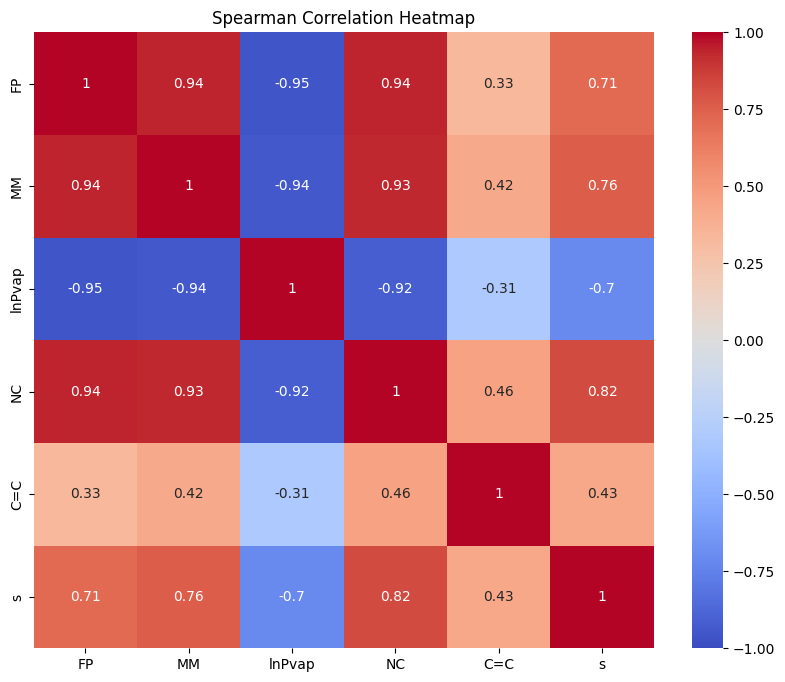

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns

DATA_PATH = Path("../data")

fp_data = pd.read_csv(DATA_PATH / "experimental" / "training_data.csv")

# Fill NaN values and remove duplicate ones, if exists
fp_data.fillna(0)
fp_data.drop_duplicates()

# Calculate Spearman correlation
selected_columns = [
    "FP",
    "MM",
    "lnPvap",
    "NC",
    "C=C",
    "s",
]  # The method column need to be desconsidered, since it related to the FP experimental method
filtered_data = fp_data[selected_columns]
spearman_corr = filtered_data.corr(method="spearman")

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Spearman Correlation Heatmap")
plt.show()

4/4 [==============================] - 0s 2ms/step - loss: 18.6034 - mae: 3.1182 - mse: 17.9346
MAE - 3.118187665939331
RMSE - 4.234925406743735
4/4 [==============================] - 0s 1ms/step


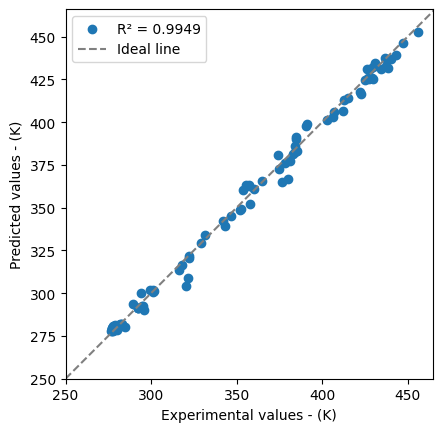

Model and scaler were succesfully saved


KeyboardInterrupt: 

In [2]:
import numpy as np
import uuid

from sklearn.model_selection import KFold
from fpnn.model_training import NeuralNet

MODELS_PATH = Path("../models")

# Remove NC, C=C and s
fp_data = fp_data.drop(columns=["NC", "C=C", "s"])

# Split features and label
features = fp_data.iloc[:, 1:].values
label = fp_data.iloc[:, 0].values

# Train model using a cross-validation loop
mae_list = []
rmse_list = []
models_rmse = {}

kf = KFold(n_splits=5, random_state=42, shuffle=True)
for train_idx, test_idx in kf.split(features):
    X_train, X_test = features[train_idx], features[test_idx]
    y_train, y_test = label[train_idx], label[test_idx]

    model_id = uuid.uuid4()

    nn_exec = NeuralNet(X_train, X_test, y_train, y_test, model_id)
    mae, mse = nn_exec.execute_training_steps(save_model_path=MODELS_PATH)

    mae_list.append(mae)
    rmse_list.append(np.sqrt(mse))
    models_rmse[model_id] = np.sqrt(mse)

print(f"Average MAE = {np.mean(mae_list)}")
print(f"Average RMSE = {np.mean(rmse_list)}")

Butanol + FAEE evaluation

In [ ]:
import pickle as pkl

from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model

# Get best model
best_model_id = min(models_rmse, key=models_rmse.get)

# Load the scaler and the model
model = load_model(MODELS_PATH / f"{best_model_id}.keras")

with open(MODELS_PATH / f"scaler_{best_model_id}.pkl", "rb") as f:
    scaler = pkl.load(f)

# Get 1-butanol + FAEE data and store the features and label values
but_data = pd.read_csv(DATA_PATH / "experimental" / "butanol_data.csv")
but_features = but_data.iloc[:, 1:].values
but_label = but_data.iloc[:, 0].values

# Predict values
but_scaled_features = scaler.transform(but_features)
but_y_pred = model.predict(but_scaled_features)

# Evaluate model metrics
but_rmse = np.sqrt(mean_squared_error(but_label, but_y_pred))
but_mae = mean_absolute_error(but_label, but_y_pred)

print(f"Butanol + FAEE RMSE = {round(but_rmse, 3)}")
print(f"Butanol + FAEE MAE = {round(but_mae, 3)}")

Ethyl decanoate + ethyl stereate evaluation

In [ ]:
# Get ethyl decanoate + ethyl stereate data and store the features and label values
faee_data = pd.read_csv(DATA_PATH / "literature" / "faee_data.csv")
faee_features = faee_data.iloc[:, 1:].values
faee_label = faee_data.iloc[:, 0].values

# Predict values
faee_scaled_features = scaler.transform(faee_features)
faee_y_pred = model.predict(faee_scaled_features)

# Evaluate model metrics
faee_rmse = np.sqrt(mean_squared_error(faee_label, faee_y_pred))
faee_mae = mean_absolute_error(faee_label, faee_y_pred)

print(f"Ethyl decanoate + Ethyl stereate RMSE = {round(faee_rmse, 3)}")
print(f"Ethyl decanoate + Ethyl stereate MAE = {round(faee_mae, 3)}")

Biodiesel evaluation

In [ ]:
# Get biodiesel data and store the features and label values
bio_data = pd.read_csv(DATA_PATH / "literature" / "biodiesel_data.csv")
bio_features = bio_data.iloc[:, 1:].values
bio_label = bio_data.iloc[:, 0].values

# Predict values
bio_scaled_features = scaler.transform(bio_features)
bio_y_pred = model.predict(bio_scaled_features)

# Evaluate model metrics
bio_rmse = np.sqrt(mean_squared_error(bio_label, bio_y_pred))
bio_mae = mean_absolute_error(bio_label, bio_y_pred)

print(f"Biodiesel RMSE = {round(bio_rmse, 3)}")
print(f"Biodiesel MAE = {round(bio_mae, 3)}")